# setup

In [1]:
import os, re, json, glob, math, sys, random
from pathlib import Path
from typing import Dict, Iterable, Optional, Sequence, Tuple, Set
from collections import defaultdict, Counter, deque

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator, ScalarFormatter

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Subset

# ----------------------------
# Project root (repo)
# ----------------------------
PROJ_ROOT = Path("/home/hernan_melmoth/Documents/phd_work/otu-taxa-foundation")
SRC_DIR = PROJ_ROOT / "src"

if str(SRC_DIR) not in sys.path:
    sys.path.append(str(SRC_DIR))

# ----------------------------
# Local package imports (src/otu_taxa)
# ----------------------------
from otu_taxa.dataloaders_unk_balanced import (
    OTUTaxaDataset,
    MaskingConfig,
    make_tax_only_mask_collator,
)

# If you still use these helper functions in your old test notebook,
# keep them. Otherwise we can remove later.
from otu_taxa.helpers_taxa_prediction import (
    load_vocab_json,
    norm_id,
    parse_tax_to_cols,
    is_unknown,
    evaluate_and_plot_predictions,
)

# UNK-aware metrics / decoding helpers
from otu_taxa.joint_hier_loss_metrics_unk import (
    hierarchical_predict_full_path,
    make_factorized_tax_loss_fn_fast_masked_with_unk,
    get_tax_path_for_label,
    deepest_taxonomy_accuracy_f1,   # often useful in testing
)

# UNK-aware model
from otu_taxa.otu_taxa_transformer_unk import (
    ModelConfig,
    OTUTaxaTransformerEmbedTaxTreeUnkTaxa,
)
from otu_taxa.helpers_pretraining_model import IGNORE_INDEX, set_seed


from otu_taxa.taxonomy_parsing import (
    load_affected_otu_ids_txt
)

# laod model

In [2]:
# ---------------------------
# Run paths (inside repo)
# ---------------------------
run_name = "pretrain_hier_joint_unk_taxa"
experiment_name = "runs_microbeatlas_genus_corruption"

RUN_DIR   = os.path.join(PROJ_ROOT, experiment_name, run_name)
META_PATH = os.path.join(RUN_DIR, "meta.json")
CKPT_PATH = os.path.join(RUN_DIR, "best.pt")

with open(META_PATH, "r") as f:
    meta = json.load(f)

# ---------------------------
# External dataset location (GENUS corruption; match training)
# ---------------------------
DATASET_ROOT = "/home/hernan_melmoth/Documents/phd_work/Microbeatlas_preprocess_training"
dataset_folder_name = meta.get("dataset_folder_name", "dataset_full_top999")

dataset_dir = os.path.join(
    DATASET_ROOT,
    "level_97",
    "silva-138.2",
    "incomplete_genus_silva_sintax",   # <- genus corruption (fixed)
    dataset_folder_name,
)

SAMPLES_JSONL = os.path.join(dataset_dir, "samples.jsonl")
TREE_DIR      = os.path.join(dataset_dir, "tree_artifacts")

assert os.path.isfile(SAMPLES_JSONL), f"Missing samples.jsonl: {SAMPLES_JSONL}"
assert os.path.isdir(TREE_DIR), f"Missing tree_artifacts dir: {TREE_DIR}"

# Affected OTUs stored with dataset artifacts
AFFECTED_OTU_IDS_PATH = os.path.join(dataset_dir, "affected_otu_ids_from_removed_genus.txt")
assert os.path.isfile(AFFECTED_OTU_IDS_PATH), f"Missing affected OTU list: {AFFECTED_OTU_IDS_PATH}"

# UNK tree artifacts (required for loss/decoding parity)
UNK_VOCAB_PATH = os.path.join(TREE_DIR, "taxonomy_vocab_with_unk.json")
UNK_M_PATH     = os.path.join(TREE_DIR, "descendant_matrix_with_unk.npy")
RANK_IDX_PATH  = os.path.join(TREE_DIR, "rank_idx.npy")

assert os.path.isfile(UNK_VOCAB_PATH), f"Missing: {UNK_VOCAB_PATH}"
assert os.path.isfile(UNK_M_PATH),     f"Missing: {UNK_M_PATH}"
assert os.path.isfile(RANK_IDX_PATH),  f"Missing: {RANK_IDX_PATH}"

print("[INFO] RUN_DIR:", RUN_DIR)
print("[INFO] dataset_dir:", dataset_dir)
print("[INFO] affected OTU list:", AFFECTED_OTU_IDS_PATH)

# ---------------------------
# Device
# ---------------------------
DEVICE = "cuda:1" if torch.cuda.is_available() else "cpu"

# ---------------------------
# Rebuild EXACT split used in training
# ---------------------------
seed   = meta.get("seed", 123)
TEST_N = meta.get("TEST_N", 20_000)
VAL_N  = meta.get("VAL_N", 20_000)

set_seed(seed)
random.seed(seed)

ds = OTUTaxaDataset(dataset_dir)
N = len(ds)
print(f"[INFO] Dataset size: N={N}")

TEST_N = min(TEST_N, N)
VAL_N  = min(VAL_N, N - TEST_N)

all_idx = list(range(N))
random.shuffle(all_idx)

test_idx  = sorted(all_idx[:TEST_N])
val_idx   = sorted(all_idx[TEST_N:TEST_N + VAL_N])
train_idx = sorted(all_idx[TEST_N + VAL_N:])

print(f"[SPLIT] Train={len(train_idx)}  Val={len(val_idx)}  Test={len(test_idx)}  (Total N={N})")

train_ds = Subset(ds, train_idx)
val_ds   = Subset(ds, val_idx)
test_ds  = Subset(ds, test_idx)

# ---------------------------
# Output location for predictions
# ---------------------------
OUT_DIR = Path(dataset_dir) / "predictions_of_taxa" / experiment_name / run_name
OUT_DIR.mkdir(parents=True, exist_ok=True)
OUT_JSONL = OUT_DIR / "pred_affected_taxonomy.jsonl"

# ---------------------------
# Model config + strict consistency checks
# ---------------------------
mc = meta.get("model_cfg")
if mc is None:
    raise KeyError("meta.json must contain 'model_cfg'.")

required_mc = ["d_model", "n_layers", "n_heads", "d_ff", "dropout", "activation"]
missing = [k for k in required_mc if k not in mc]
if missing:
    raise KeyError(f"meta['model_cfg'] missing required keys: {missing}")

ds_meta = meta.get("dataset", {})
if not ds_meta:
    raise KeyError("meta.json must contain 'dataset' with O/T info.")

O_ds = ds.O
T_real_ds = ds.T

mO     = ds_meta.get("O")
T_real = ds_meta.get("T_real")
T_base = ds_meta.get("T_base")

if mO is None or T_real is None or T_base is None:
    raise KeyError("meta['dataset'] must contain 'O', 'T_real', 'T_base'.")

if mO != O_ds:
    raise ValueError(f"Dataset O mismatch: meta O={mO}, dataset O={O_ds}")

if T_real != T_real_ds:
    raise ValueError(f"Dataset T_real mismatch: meta T_real={T_real}, dataset T={T_real_ds}")

pad_otu_id  = O_ds
mask_otu_id = O_ds + 1

pad_tax_id  = T_base
mask_tax_id = T_base + 1

n_otus = O_ds + 2
n_taxa = T_base + 2

# ---------------------------
# Load UNK artifacts
# ---------------------------
with open(UNK_VOCAB_PATH, "r") as f:
    tax_vocab_unk = json.load(f)
if len(tax_vocab_unk) != T_base:
    raise ValueError(f"UNK vocab length mismatch: len={len(tax_vocab_unk)} vs T_base={T_base}")

M_np = np.load(UNK_M_PATH)
if M_np.shape != (T_base, T_base):
    raise ValueError(f"Descendant matrix shape mismatch: {M_np.shape} vs expected {(T_base, T_base)}")

rank_idx = np.load(RANK_IDX_PATH)
if rank_idx.shape[0] != T_base:
    raise ValueError(f"rank_idx length mismatch: {rank_idx.shape} vs T_base={T_base}")

M_tensor = torch.from_numpy(M_np).to(DEVICE)
rank_idx_t = torch.from_numpy(rank_idx).to(DEVICE)

# ---------------------------
# Build loss fn (parity with training)
# ---------------------------
hier_tax_loss_fn = make_factorized_tax_loss_fn_fast_masked_with_unk(
    M_tensor=M_tensor,
    rank_idx=rank_idx_t,
    tax_vocab=tax_vocab_unk,
    T_base=T_base,
)

# ---------------------------
# Instantiate model + strict checkpoint load
# ---------------------------
cfg = ModelConfig(**mc)

model = OTUTaxaTransformerEmbedTaxTreeUnkTaxa(
    n_otus=n_otus,
    n_taxa=n_taxa,
    pad_otu_id=pad_otu_id,
    pad_tax_id=pad_tax_id,
    config=cfg,
    tax_loss_fn=hier_tax_loss_fn,
)

raw = torch.load(CKPT_PATH, map_location="cpu")
if not isinstance(raw, dict):
    raise TypeError("Checkpoint must be a dict-like object.")

if "model" in raw and isinstance(raw["model"], dict):
    sd = raw["model"]
elif "state_dict" in raw and isinstance(raw["state_dict"], dict):
    sd = raw["state_dict"]
else:
    raise KeyError("Checkpoint must contain either 'model' or 'state_dict'.")

def strip_prefix_if_all(state_dict, prefix):
    keys = list(state_dict.keys())
    if keys and all(k.startswith(prefix) for k in keys):
        return {k[len(prefix):]: v for k, v in state_dict.items()}
    return state_dict

sd = strip_prefix_if_all(sd, "model.")
sd = strip_prefix_if_all(sd, "module.")

model.load_state_dict(sd, strict=True)
model.to(DEVICE).eval()

print("[OK] strict load succeeded; model on", DEVICE)
print(f"[INFO] O={O_ds}, T_real={T_real}, T_base={T_base}, n_taxa={n_taxa}")
print(f"[INFO] OUT_JSONL={OUT_JSONL}")

# ---------------------------
# tax_id -> name mapping (base+UNK, length T_base)
# ---------------------------
tax_id2name = {i: name for i, name in enumerate(tax_vocab_unk)}
if len(tax_id2name) != T_base:
    raise ValueError(f"tax_id2name size mismatch: len={len(tax_id2name)} vs T_base={T_base}")

print(f"[INFO] tax_id2name created (size={len(tax_id2name)})")
print(f"[INFO] preview taxonomy names: {[tax_id2name[i] for i in range(min(5, T_base))]}")


[INFO] RUN_DIR: /home/hernan_melmoth/Documents/phd_work/otu-taxa-foundation/runs_microbeatlas_genus_corruption/pretrain_hier_joint_unk_taxa
[INFO] dataset_dir: /home/hernan_melmoth/Documents/phd_work/Microbeatlas_preprocess_training/level_97/silva-138.2/incomplete_genus_silva_sintax/dataset_full_top999
[INFO] affected OTU list: /home/hernan_melmoth/Documents/phd_work/Microbeatlas_preprocess_training/level_97/silva-138.2/incomplete_genus_silva_sintax/dataset_full_top999/affected_otu_ids_from_removed_genus.txt
[INFO] Dataset size: N=1836250
[SPLIT] Train=1796250  Val=20000  Test=20000  (Total N=1836250)
UNK ids per rank: [6114, 6115, 6116, 6117, 6118, 6119, 6120]


/home/hernan_melmoth/anaconda3/envs/bio_ontology_env/lib/python3.9/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


[OK] strict load succeeded; model on cuda:1
[INFO] O=62200, T_real=6115, T_base=6121, n_taxa=6123
[INFO] OUT_JSONL=/home/hernan_melmoth/Documents/phd_work/Microbeatlas_preprocess_training/level_97/silva-138.2/incomplete_genus_silva_sintax/dataset_full_top999/predictions_of_taxa/runs_microbeatlas_genus_corruption/pretrain_hier_joint_unk_taxa/pred_affected_taxonomy.jsonl
[INFO] tax_id2name created (size=6121)
[INFO] preview taxonomy names: ['c:028H05-P-BN-P5', 'c:055B07-P-DI-P58', 'c:113B434', 'c:AB64A-17', 'c:AEGEAN-245']


# predictions

In [3]:
def load_affected_otu_ids_txt(path: str, otu_name2id: dict) -> Set[int]:
    """
    Load affected OTUs from a text file.
    Supports:
      - integer OTU ids (as strings)
      - OTU names like '90_1015;96_21955;97_71802'
    """
    ids = set()
    missing = []

    with open(path, "r") as f:
        for line in f:
            s = line.strip()
            if not s:
                continue

            # Case 1: already an integer OTU id
            if s.isdigit():
                ids.add(int(s))
                continue

            # Case 2: OTU name → map to id
            if otu_name2id is not None and s in otu_name2id:
                ids.add(int(otu_name2id[s]))
            else:
                missing.append(s)

    if missing:
        print(
            f"[WARN] {len(missing)} affected OTUs could not be mapped to dataset OTU ids "
            f"(showing first 10): {missing[:10]}"
        )

    return ids


In [4]:
# --------------------------------------------------------- 
# 0) Reproducibility for the OTU selection step
# ---------------------------------------------------------
seed = meta.get("seed", 123)
random.seed(seed)


# ---------------------------------------------------------
# 1) OTU vocab mappings (optional; keep as-is)
# ---------------------------------------------------------
otu_vocab_candidates = [
    os.path.join(dataset_dir, "otu_vocab.json"),
    os.path.join(TREE_DIR, "otu_vocab.json"),
]
otu_vocab_path = next((p for p in otu_vocab_candidates if os.path.isfile(p)), None)

otu_id2name = None
otu_name2id = None
if otu_vocab_path is not None:
    with open(otu_vocab_path, "r") as f:
        otu_vocab = json.load(f)
    if isinstance(otu_vocab, dict):
        otu_id2name = {int(k): v for k, v in otu_vocab.items()}
        otu_name2id = {v: k for k, v in otu_id2name.items()}
    elif isinstance(otu_vocab, list):
        otu_id2name = {i: n for i, n in enumerate(otu_vocab)}
        otu_name2id = {n: i for i, n in otu_id2name.items()}
    print(f"[INFO] Loaded OTU vocab: {otu_vocab_path}  (size={len(otu_id2name)})")
else:
    print("[WARN] OTU vocab json not found; proceeding without names (IDs only).")


affected_otu_ids = load_affected_otu_ids_txt(
    AFFECTED_OTU_IDS_PATH,
    otu_name2id=otu_name2id,
)

print(f"[AFFECTED] preview: {sorted(list(affected_otu_ids))[:20]}")


# ---------------------------------------------------------
# 2) Sanity check dataset sizes (parity with model block)
# ---------------------------------------------------------
O_eval, T_real_eval = ds.O, ds.T
if O_eval != O_ds:
    raise ValueError(f"OTU mismatch: model block O={O_ds}, dataset O={O_eval}")
if T_real_eval != T_real:
    raise ValueError(f"T_real mismatch: model meta T_real={T_real}, dataset T={T_real_eval}")

print(f"[INFO] Eval setup: O={O_eval}, T_real={T_real_eval}, T_base={T_base}")

# ---------------------------------------------------------
# 3) Build OTU pool from test_ds (Subset) (keep as-is)
# ---------------------------------------------------------
def build_otu_pool_from_subset(subset_ds, otu_key="otus", probe=None, return_counts=True):
    pool = set()
    counts = Counter()
    n_seen = 0

    L = len(subset_ds)
    limit = L if probe is None else min(L, int(probe))

    for i in range(limit):
        rec = subset_ds[i]
        if not isinstance(rec, dict):
            continue
        otus = rec.get(otu_key, [])
        if torch.is_tensor(otus):
            otus = otus.view(-1).tolist()
        for o in otus:
            oi = int(o.item() if torch.is_tensor(o) else o)
            pool.add(oi)
            if return_counts:
                counts[oi] += 1
        n_seen += 1

    return (pool, counts, n_seen) if return_counts else (pool, n_seen)

otu_pool, otu_counts, n_seen = build_otu_pool_from_subset(test_ds, otu_key="otus", probe=None, return_counts=True)

print(f"[POOL] scanned test samples: {n_seen}")
print(f"[POOL] unique OTUs in test set: {len(otu_pool)}")
print(f"[POOL] preview OTU IDs: {sorted(list(otu_pool))[:15]}")

# ---------------------------------------------------------
# 4) REPLACE random OTUs with: affected OTUs intersect test OTU pool
# ---------------------------------------------------------
mask_otu_ids = sorted(list(affected_otu_ids.intersection(otu_pool)))

print(f"[AFFECTED∩TEST] affected OTUs present in test set: {len(mask_otu_ids):,}")
if len(affected_otu_ids) > 0:
    print(f"[AFFECTED∩TEST] coverage: {len(mask_otu_ids)/float(len(affected_otu_ids)):.2%} "
          f"(of all affected OTUs)")
print(f"[AFFECTED∩TEST] preview: {mask_otu_ids[:20]}")

if len(mask_otu_ids) == 0:
    raise ValueError(
        "No affected OTUs appear in the test set. "
        "Check OTU id space alignment between affected list and OTUTaxaDataset."
    )

# Optional: frequencies in test set (kept from your original logic)
freq_preview = [(oid, otu_counts.get(oid, 0)) for oid in mask_otu_ids[:15]]
print("[AFFECTED∩TEST] frequency preview (otu_id, count_in_test_scan):")
print(freq_preview)

# ---------------------------------------------------------
# 5) Descendant matrix + rank_idx loading
# IMPORTANT: you already loaded these in the earlier model block.
# Keep this ONLY if you intentionally want a second check on CPU.
# Otherwise, delete to avoid redundant loads.
# ---------------------------------------------------------
# If you keep it, it is functionally OK, but redundant.

if not os.path.isfile(UNK_M_PATH):
    raise FileNotFoundError(f"Missing UNK descendant matrix: {UNK_M_PATH}")

M_np = np.load(UNK_M_PATH)  # expected shape [T_base, T_base]
if M_np.shape != (T_base, T_base):
    raise ValueError(
        f"descendant_matrix_with_unk shape mismatch: "
        f"expected ({T_base}, {T_base}), got {M_np.shape}"
    )

M_tensor = torch.from_numpy(M_np)  # CPU tensor

if not os.path.isfile(RANK_IDX_PATH):
    raise FileNotFoundError(f"Missing rank_idx.npy: {RANK_IDX_PATH}")

rank_idx_np = np.load(RANK_IDX_PATH)  # expected shape [T_base]
if rank_idx_np.shape[0] != T_base:
    raise ValueError(
        f"rank_idx length mismatch: expected ({T_base},), got {rank_idx_np.shape}"
    )

valid = set([-1, 0, 1, 2, 3, 4, 5, 6])
bad = sorted(set(int(x) for x in np.unique(rank_idx_np)) - valid)
if bad:
    raise ValueError(f"rank_idx contains invalid values: {bad}")

rank_idx = torch.from_numpy(rank_idx_np.astype(np.int64))  # CPU tensor, long

M_dev = M_tensor.to(DEVICE)
rank_idx_dev = rank_idx.to(DEVICE)

print(
    f"[INFO] descendant_matrix_with_unk loaded from: {UNK_M_PATH}, "
    f"shape={M_np.shape}"
)
print(
    f"[INFO] rank_idx loaded from: {RANK_IDX_PATH}, "
    f"shape={rank_idx_np.shape}, unique={sorted(set(rank_idx_np.tolist()))}"
)


[INFO] Loaded OTU vocab: /home/hernan_melmoth/Documents/phd_work/Microbeatlas_preprocess_training/level_97/silva-138.2/incomplete_genus_silva_sintax/dataset_full_top999/otu_vocab.json  (size=62200)
[WARN] 5050 affected OTUs could not be mapped to dataset OTU ids (showing first 10): ['90_3972;96_64159;97_83210', '90_1;96_62565;97_81083', '90_2424;96_29098;97_36694', '90_15;96_91;97_43264', '90_120;96_346;97_58657', '90_364;96_1570;97_1874', '90_23;96_18324;97_22626', '90_23;96_54125;97_69810', '90_18056;96_71621;97_93077', '90_8485;96_36833;97_46805']
[AFFECTED] preview: [1, 2, 8, 9, 23, 25, 39, 45, 54, 72, 73, 99, 116, 120, 131, 169, 175, 182, 187, 190]
[INFO] Eval setup: O=62200, T_real=6115, T_base=6121
[POOL] scanned test samples: 20000
[POOL] unique OTUs in test set: 59446
[POOL] preview OTU IDs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
[AFFECTED∩TEST] affected OTUs present in test set: 6,067
[AFFECTED∩TEST] coverage: 95.65% (of all affected OTUs)
[AFFECTED∩TEST] preview:

In [5]:
# import torch

# def make_tax_only_mask_collator(dataset, affected_ids, *, T_base: int, max_len=None):
#     O = dataset.O
#     pad_otu_id, mask_otu_id = O, O + 1

#     pad_tax_id, mask_tax_id = T_base, T_base + 1  # IMPORTANT (matches model)

#     affected_ids = set(map(int, affected_ids))

#     def collate(batch):
#         lengths = [len(b["otus"]) for b in batch]
#         L = max_len if max_len is not None else max(lengths)
#         B = len(batch)

#         input_otus = torch.full((B, L), pad_otu_id, dtype=torch.long)
#         input_taxa = torch.full((B, L), pad_tax_id, dtype=torch.long)
#         attention_mask = torch.zeros((B, L), dtype=torch.bool)

#         masked_positions = []
#         sample_ids = []
#         true_taxa = []

#         for i, rec in enumerate(batch):
#             otus = torch.tensor(rec["otus"], dtype=torch.long)
#             taxa = torch.tensor(rec["taxa"], dtype=torch.long)

#             L_i = min(L, len(otus))
#             input_otus[i, :L_i] = otus[:L_i]
#             input_taxa[i, :L_i] = taxa[:L_i]
#             attention_mask[i, :L_i] = True

#             aff_mask = torch.tensor(
#                 [int(int(x) in affected_ids) for x in otus[:L_i]],
#                 dtype=torch.bool
#             )

#             input_taxa[i, :L_i][aff_mask] = mask_tax_id

#             pos_idx = torch.nonzero(aff_mask, as_tuple=False).view(-1).tolist()
#             masked_positions.append(pos_idx)

#             sample_ids.append(rec["sample_id"])

#             # FIX: store the aligned/truncated gold taxonomy for this sample
#             gold = torch.full((L,), pad_tax_id, dtype=torch.long)
#             gold[:L_i] = taxa[:L_i]
#             true_taxa.append(gold)

#         return {
#             "input_otus": input_otus,
#             "input_taxa": input_taxa,
#             "attention_mask": attention_mask,
#             "masked_positions": masked_positions,
#             "sample_ids": sample_ids,
#             "true_taxa": true_taxa,  # list[Tensor(L,)]
#         }

#     return collate


In [6]:
# -------------------------
# Output (UPDATED: distinguish affected vs random)
# -------------------------
PRED_DIR = Path(RUN_DIR) / "predictions"
PRED_DIR.mkdir(parents=True, exist_ok=True)

# Tag this experiment explicitly
AFFECTED_TAG = "affected_removed_genus_20pct_seed123"

OUT_JSONL_AFFECTED = PRED_DIR / f"pred_{AFFECTED_TAG}_taxonomy_per_rank.jsonl"
if OUT_JSONL_AFFECTED.exists():
    OUT_JSONL_AFFECTED.unlink()

print(f"[INFO] Writing AFFECTED-OTU predictions to: {OUT_JSONL_AFFECTED}")

RANK_LETTERS = ['k', 'p', 'c', 'o', 'f', 'g', 's']

# -------------------------
# Choose AFFECTED OTUs 
# -------------------------
# You should already have:
#   affected_otu_ids : Set[int]   (mapped to dataset id space)
#   otu_pool         : Set[int]   (from test set scan)
# We restrict to those actually appearing in test set:
affected_in_test = set(affected_otu_ids).intersection(otu_pool)

print(f"[AFFECTED] total affected OTUs loaded: {len(affected_otu_ids):,}")
print(f"[AFFECTED∩TEST] affected OTUs present in test set: {len(affected_in_test):,}")
print(f"[AFFECTED∩TEST] preview: {sorted(list(affected_in_test))[:15]}")

if len(affected_in_test) == 0:
    raise ValueError(
        "No affected OTUs appear in the test set. "
        "Check OTU-id mapping and the affected list definition."
    )

mask_otu_ids = affected_in_test  # name kept for parity with old loop

# -------------------------
# KEEP existing collator (unchanged), but use affected IDs
# -------------------------
max_len = meta.get("max_len", 500)  # keep as before
collate = make_tax_only_mask_collator(ds, mask_otu_ids, T_base=T_base, max_len=500)

# -------------------------
# Batch iterator over test_ds only
# Same logic: keep only samples that contain ≥1 target OTU
# -------------------------
def batch_iter_only_affected_subset(subset, batch_size: int, affected_ids: set):
    batch = []
    matched = 0

    for i in range(len(subset)):
        rec = subset[i]

        otus = rec.get("otus", [])
        if torch.is_tensor(otus):
            otus = otus.view(-1).tolist()

        if set(map(int, otus)) & affected_ids:
            matched += 1
            batch.append(rec)
            if len(batch) == batch_size:
                yield collate(batch)
                batch.clear()

    if batch:
        yield collate(batch)

    print(f"[INFO] TEST filtering: subset size={len(subset)} | matched with ≥1 target OTU: {matched}")

# -------------------------
# Helpers for name mapping (robust)
# -------------------------
def _tax_name(tid: int):
    if "tax_id2name" in globals() and tax_id2name is not None:
        if isinstance(tax_id2name, dict):
            return tax_id2name.get(int(tid), f"<id:{int(tid)}>")
        if isinstance(tax_id2name, list) and 0 <= tid < len(tax_id2name):
            return tax_id2name[tid]
    if "tax_vocab_unk" in globals() and tax_vocab_unk is not None:
        if isinstance(tax_vocab_unk, dict):
            return tax_vocab_unk.get(str(int(tid)), tax_vocab_unk.get(int(tid), f"<id:{int(tid)}>"))
        if isinstance(tax_vocab_unk, list) and 0 <= tid < len(tax_vocab_unk):
            return tax_vocab_unk[tid]
    return f"<id:{int(tid)}>"

def _otu_name(oid: int):
    if "otu_id2name" in globals() and otu_id2name is not None:
        return otu_id2name.get(int(oid), f"<otu:{int(oid)}>")
    return f"<otu:{int(oid)}>"

# -------------------------
# Prediction loop (UNCHANGED except output path variable)
# -------------------------
BATCH_SIZE = 4
total_samples = 0
total_masked_positions = 0

model.eval()
with torch.no_grad():
    with open(OUT_JSONL_AFFECTED, "w") as fjsonl:
        for batch in batch_iter_only_affected_subset(
            test_ds, BATCH_SIZE, mask_otu_ids
        ):
            input_otus = batch["input_otus"].to(DEVICE)
            input_taxa = batch["input_taxa"].to(DEVICE)
            attn_mask  = batch["attention_mask"].to(DEVICE)

            out = model(
                input_otus=input_otus,
                input_taxa=input_taxa,
                attention_mask=attn_mask,
            )

            logits_tax = None
            for k in ("logits_tax", "tax_logits", "logits_taxa"):
                if isinstance(out, dict) and k in out:
                    logits_tax = out[k]
                    break
            if logits_tax is None:
                raise KeyError("Model forward output does not contain taxonomy logits.")

            # block PAD_TAX and MASK_TAX (indices T_base, T_base+1)
            if pad_tax_id < logits_tax.size(-1):
                logits_tax[:, :, pad_tax_id] = float("-inf")
            if mask_tax_id < logits_tax.size(-1):
                logits_tax[:, :, mask_tax_id] = float("-inf")

            for bi, sid in enumerate(batch["sample_ids"]):
                pos_list = batch["masked_positions"][bi]
                if not pos_list:
                    continue
                total_samples += 1

                true_seq = batch["true_taxa"][bi]

                for pos in pos_list:
                    logits_vec = logits_tax[bi, pos]
                    logits_base = logits_vec[:T_base]

                    path_pred = hierarchical_predict_full_path(
                        logits_vec=logits_base,
                        M_tensor=M_dev,
                        rank_idx=rank_idx_dev,
                        R=7,
                    )

                    pred_by_rank = {}
                    for r, ch in enumerate(RANK_LETTERS):
                        pid = path_pred.get(r, None)
                        if pid is None:
                            continue
                        pred_by_rank[ch] = {
                            "tax_id": int(pid),
                            "tax_name": _tax_name(int(pid)),
                        }

                    true_val = true_seq[pos]
                    true_tid = int(true_val.item() if torch.is_tensor(true_val) else true_val)

                    otu_id = int(batch["input_otus"][bi, pos].item())

                    if 0 <= true_tid < T_base:
                        r_true = int(rank_idx_dev[true_tid].item())
                    else:
                        r_true = -1

                    if 0 <= r_true < len(RANK_LETTERS):
                        ch_true = RANK_LETTERS[r_true]
                        pid_deep = path_pred.get(r_true, None)
                        pred_flat = {
                            "tax_id": int(pid_deep) if pid_deep is not None else None,
                            "tax_name": _tax_name(int(pid_deep)) if pid_deep is not None else None,
                            "rank": ch_true,
                        }
                    else:
                        pred_flat = {"tax_id": None, "tax_name": None, "rank": None}

                    rec = {
                        "sample_id": sid,
                        "position": int(pos),
                        "otu_id": int(otu_id),
                        "otu_name": _otu_name(int(otu_id)),
                        "true_tax_id": int(true_tid),
                        "true_tax_name": _tax_name(int(true_tid)),
                        "pred_flat": pred_flat,
                        "pred_by_rank": pred_by_rank,
                        # Optional but useful provenance tag:
                        "experiment_tag": AFFECTED_TAG,
                    }

                    fjsonl.write(json.dumps(rec) + "\n")
                    total_masked_positions += 1

print(f"[DONE] wrote AFFECTED predictions to: {OUT_JSONL_AFFECTED}")
print(f"[INFO] samples with ≥1 masked affected OTU: {total_samples}")
print(f"[INFO] total masked positions (affected OTUs): {total_masked_positions}")


[INFO] Writing AFFECTED-OTU predictions to: /home/hernan_melmoth/Documents/phd_work/otu-taxa-foundation/runs_microbeatlas_genus_corruption/pretrain_hier_joint_unk_taxa/predictions/pred_affected_removed_genus_20pct_seed123_taxonomy_per_rank.jsonl
[AFFECTED] total affected OTUs loaded: 6,343
[AFFECTED∩TEST] affected OTUs present in test set: 6,067
[AFFECTED∩TEST] preview: [1, 2, 8, 9, 23, 25, 39, 45, 54, 72, 73, 99, 116, 120, 131]
[INFO] TEST filtering: subset size=20000 | matched with ≥1 target OTU: 18597
[DONE] wrote AFFECTED predictions to: /home/hernan_melmoth/Documents/phd_work/otu-taxa-foundation/runs_microbeatlas_genus_corruption/pretrain_hier_joint_unk_taxa/predictions/pred_affected_removed_genus_20pct_seed123_taxonomy_per_rank.jsonl
[INFO] samples with ≥1 masked affected OTU: 18597
[INFO] total masked positions (affected OTUs): 341617


# predictions print

In [7]:
from otu_taxa.metrics_figures import (
    evaluate_and_plot_predictions_multilabel, 
    plot_per_level_accuracy_hierarchical_from_arrays, 
    load_predictions_with_pred_gold, 
    strict_error_origin_matrix_and_rankACC, 
    plot_strict_matrix_with_rankACC, 
    plot_error_origin_matrix_rowpct_colored,
    compute_global_rankACC, 
    build_accuracy_vs_rankACC_table
)

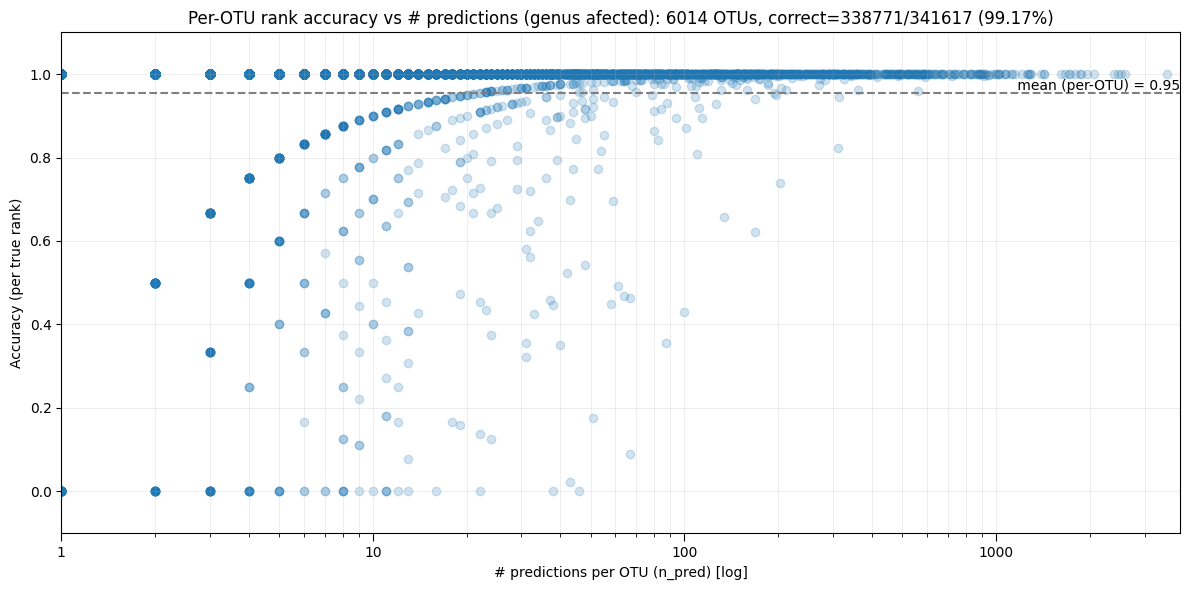

[INFO] multilabel eval: 18597 unique samples, 341617 predictions, 6014 OTUs | correct=338771/341617 (99.17%)


In [8]:
df_raw, df_otu, summary, fig = evaluate_and_plot_predictions_multilabel(
    jsonl_path=OUT_JSONL_AFFECTED,
    title_prefix="Per-OTU rank accuracy vs # predictions (genus afected)"
)


In [9]:
from otu_taxa.dataloaders_unk_balanced import build_tax2ancestor_at_rank, build_tax2rank_from_vocab 

RANKS = ("k","p","c","o","f","g","s")

# M_np must be the descendant closure used by the hierarchical loss: shape [T_base, T_base]
# tax_vocab_list must be length T_base (UNK-extended)
tax2rank = build_tax2rank_from_vocab(tax_vocab_unk)

ancestor_at_rank = {
    r: build_tax2ancestor_at_rank(
        M_np=M_np,                    # np.ndarray [T_base, T_base]
        tax_vocab_list=tax_vocab_unk,  # list[str] length T_base
        target_rank=r,
        missing_value=-1,
    )
    for r in RANKS
}

# quick sanity
for r in RANKS:
    assert len(ancestor_at_rank[r]) == M_np.shape[0]
print("[OK] built ancestor arrays for ranks:", RANKS)


[OK] built ancestor arrays for ranks: ('k', 'p', 'c', 'o', 'f', 'g', 's')


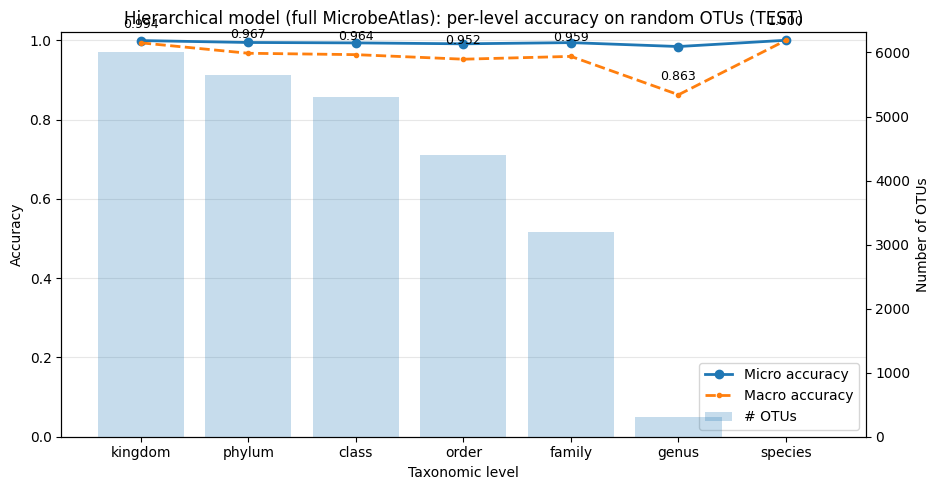

[INFO] overall micro (avg over levels) = 0.994, mean macro (avg over levels) = 0.957


,level,n_rows_used,n_otus_used,micro_acc,macro_acc
0,kingdom,341617,6014,0.9992,0.9935
1,phylum,324205,5644,0.9944,0.9672
2,class,301038,5301,0.9934,0.9637
3,order,266824,4404,0.9910,0.9522
4,family,194928,3195,0.9941,0.9593
5,genus,19307,305,0.9842,0.8626
6,species,35,2,1.0000,1.0000


In [10]:
JSONL_PER_RANK = OUT_JSONL_AFFECTED  # 

df_all, per_level_summary, overall, fig = plot_per_level_accuracy_hierarchical_from_arrays(
    jsonl_path=JSONL_PER_RANK,
    ancestor_at_rank=ancestor_at_rank,
    test_ids=None,  
    ranks=("k","p","c","o","f","g","s"),
    title="Hierarchical model (full MicrobeAtlas): per-level accuracy on random OTUs (TEST)"
)

display(per_level_summary)


In [11]:
RANKS = ("k","p","c","o","f","g","s")

# ------------------------------------------------------------
# 0) Build gold ancestor arrays 
# ------------------------------------------------------------
def build_ancestor_arrays_all_ranks(M_np, tax_vocab_unk, ranks=RANKS, missing_value=-1):
    """
    Returns dict rank -> dense list length T_base:
      ancestor_at_rank[r][t] = ancestor tax_id at rank r, else -1.
    """
    ancestor_at_rank = {}
    for r in ranks:
        ancestor_at_rank[r] = build_tax2ancestor_at_rank(
            M_np=M_np,
            tax_vocab_list=tax_vocab_unk,
            target_rank=r,
            missing_value=missing_value,
        )
    return ancestor_at_rank

ancestor_at_rank = build_ancestor_arrays_all_ranks(
    M_np=M_np,                 # [T_base, T_base] np.ndarray
    tax_vocab_unk=tax_vocab_unk,
    ranks=RANKS,
    missing_value=-1,
)
df = load_predictions_with_pred_gold(
    jsonl_path=JSONL_PER_RANK,   # your JSONL path
    ancestor_at_rank=ancestor_at_rank,
    ranks=RANKS,
)
counts_strict, meta_strict = strict_error_origin_matrix_and_rankACC(df, ranks=RANKS)


# 5) Global rankACC
global_rankACC, df_with_rankacc = compute_global_rankACC(df, ranks=RANKS)
print(f"Global rankACC: {global_rankACC:.4f}")


Global rankACC: 0.9947


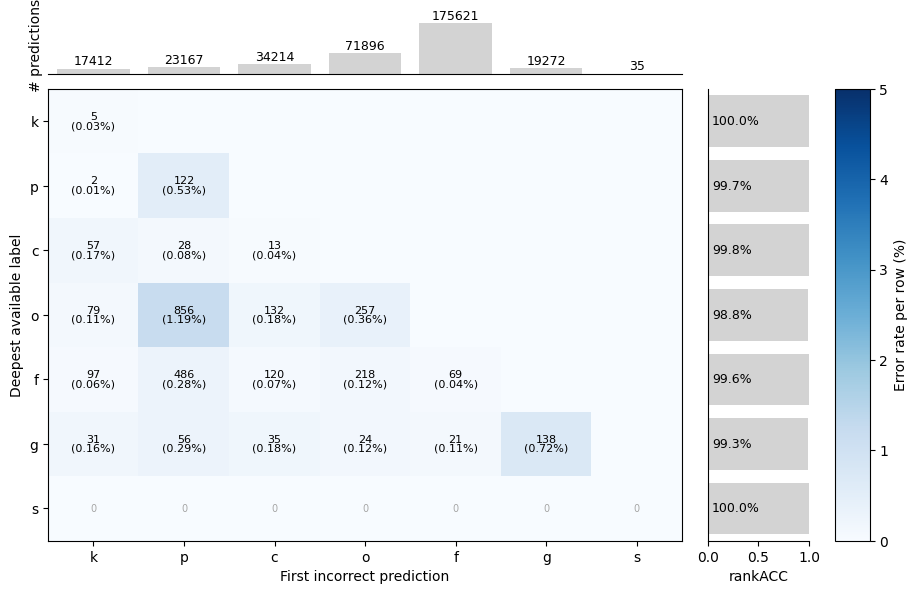

In [12]:
fig, axes = plot_error_origin_matrix_rowpct_colored(
    counts_strict,
    meta_strict,
    title= "",#"Deepest-rank error origin (TEST)",
    ranks=RANKS,
    df=df,
    otu_col="otu_id",
    show_zeros_lower=True,
    show_percent_text=True,  
    vmax_pct=5.0,            
    vmin_pct=0.0,
)


In [13]:
acc_table = build_accuracy_vs_rankACC_table(df, ranks=RANKS)
display(
    acc_table
    .assign(
        standard_accuracy=lambda x: x["standard_accuracy"].map(lambda v: f"{v:.4f}" if pd.notna(v) else "—"),
        rankACC=lambda x: x["rankACC"].map(lambda v: f"{v:.4f}" if pd.notna(v) else "—"),
    )
)


,standard_accuracy,rankACC,n_rows
k,0.9997,0.9997,17412
p,0.9946,0.9973,23167
c,0.9971,0.9977,34214
o,0.9816,0.9882,71896
f,0.9944,0.9962,175621
g,0.9842,0.9926,19272
s,1.0000,1.0000,35
Global,0.9917,0.9947,341617


# predictions vs real wround true label (vs not corrupted silva)

In [14]:

RANKS = ("k","p","c","o","f","g","s")

def strip_rank_prefix(x: str) -> str:
    if not isinstance(x, str):
        return ""
    x = x.strip()
    if ":" in x:
        return x.split(":", 1)[1].strip()
    return x

def extract_pred_rank_name(pb, r: str) -> str:
    # pb is pred_by_rank dict
    if not isinstance(pb, dict):
        return ""
    rr = pb.get(r, None)
    if not isinstance(rr, dict):
        return ""
    name = rr.get("tax_name", "")
    return strip_rank_prefix(name)

pred_path = Path(OUT_JSONL_AFFECTED)  # set your affected JSONL here
dfp = pd.read_json(pred_path, lines=True)

# this must match SINTAX OTU id string
# (your JSONL already has otu_name)
dfp["otu_key"] = dfp["otu_name"].astype(str)

# predicted names per rank
for r in RANKS:
    dfp[f"pred_{r}_name"] = dfp["pred_by_rank"].apply(lambda d: extract_pred_rank_name(d, r))


In [15]:

true_path = "/home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/level_97/taxonomy_reference/silva-138.2/vsearch_all_OTUs/repseqs_sintax_v123.txt"

def load_sintax_table(path: str) -> pd.DataFrame:
    # tries common formats: (otu_id, ..., taxonomy) or (otu_id, raw_sintax)
    try:
        df = pd.read_csv(path, sep="\t", header=None, engine="python",
                         usecols=[0,3], names=["otu_id","taxonomy"], dtype=str)
    except Exception:
        df_raw = pd.read_csv(path, sep="\t", header=None, engine="python",
                             usecols=[0,1], names=["otu_id","raw_sintax"], dtype=str)
        def drop_conf(s):
            if pd.isna(s): return ""
            parts = [p.split("(",1)[0].strip() for p in s.strip().rstrip(";").split(",") if ":" in p]
            return ",".join(parts)
        df_raw["taxonomy"] = df_raw["raw_sintax"].apply(drop_conf)
        df = df_raw[["otu_id","taxonomy"]]
    df["taxonomy"] = df["taxonomy"].fillna("")
    return df

def parse_tax_to_cols(series: pd.Series) -> pd.DataFrame:
    ranks = ["k","p","c","o","f","g","s"]
    def to_dict(tax):
        out = {r:"" for r in ranks}
        for part in str(tax).strip().rstrip(";").split(","):
            if ":" not in part: 
                continue
            r, name = part.split(":", 1)
            r = r.strip()
            name = name.split("(", 1)[0].strip()
            if r in out:
                out[r] = name
        return pd.Series(out)
    return series.apply(to_dict)

true_df = load_sintax_table(true_path)
true_cols = parse_tax_to_cols(true_df["taxonomy"])

dft = pd.concat([true_df[["otu_id"]], true_cols], axis=1)
dft = dft.rename(columns={r: f"true_{r}_name" for r in RANKS})

# join key: OTU string id
dft["otu_key"] = dft["otu_id"].astype(str)


RANKS = ("k","p","c","o","f","g","s")

PRED_PATH = Path(OUT_JSONL_AFFECTED)   # or OUT_JSONL_RANDOM
dfp = pd.read_json(str(PRED_PATH), lines=True)

# Join key: prediction OTU string (matches true_df["otu_id"])
dfp["otu_key"] = dfp["otu_name"].astype(str).str.strip()
print("[PRED] rows:", len(dfp), "| unique OTUs:", dfp["otu_key"].nunique())
print("[PRED] preview otu_key:", dfp["otu_key"].head(5).tolist())

dft["otu_key"] = dft["otu_key"].astype(str).str.strip()
print("[TRUE] rows:", len(dft), "| unique OTUs:", dft["otu_key"].nunique())
print("[TRUE] preview otu_key:", dft["otu_key"].head(5).tolist())




[PRED] rows: 341617 | unique OTUs: 6014
[PRED] preview otu_key: ['90_5222;96_23610;97_29517', '90_267;96_2422;97_2949', '90_182;96_602;97_705', '90_284;96_44244;97_56666', '90_15358;96_41933;97_53597']
[TRUE] rows: 111870 | unique OTUs: 111870
[TRUE] preview otu_key: ['90_18938;96_79042;97_101874', '90_20463;96_79800;97_102794', '90_22156;96_86043;97_110485', '90_19327;96_77520;97_100055', '90_20463;96_79800;97_102793']


In [16]:
df_join = dfp.merge(
    dft.drop(columns=["otu_id"]),   # keep otu_key + true_*_name
    on="otu_key",
    how="left",
    validate="many_to_one"
)

missing = df_join["true_p_name"].isna().mean()
print(f"[JOIN] missing true taxonomy rows: {missing:.2%}")
print("[JOIN] rows:", len(df_join))


[JOIN] missing true taxonomy rows: 0.00%
[JOIN] rows: 341617


In [17]:
def _strip_rank_prefix(s: str) -> str:
    if not isinstance(s, str):
        return ""
    s = s.strip()
    if ":" in s:
        return s.split(":", 1)[1].strip()
    return s

def _pred_name_for_rank(pred_by_rank, r: str) -> str:
    if not isinstance(pred_by_rank, dict):
        return ""
    x = pred_by_rank.get(r, None)
    if not isinstance(x, dict):
        return ""
    return _strip_rank_prefix(x.get("tax_name", ""))

for r in RANKS:
    df_join[f"pred_{r}_name"] = df_join["pred_by_rank"].apply(lambda d: _pred_name_for_rank(d, r))

df_join[["otu_key", "true_p_name", "pred_p_name", "true_g_name", "pred_g_name"]].head(10)

def _is_missing_name(x: str) -> bool:
    return (not isinstance(x, str)) or (x.strip() == "") or (x.strip().lower() in {"unknown", "__unknown"})

rows = []
for r in RANKS:
    gold = df_join[f"true_{r}_name"].fillna("").astype(str)
    pred = df_join[f"pred_{r}_name"].fillna("").astype(str)

    valid = ~gold.apply(_is_missing_name)
    n_eval = int(valid.sum())
    acc = float((pred[valid] == gold[valid]).mean()) if n_eval > 0 else float("nan")

    rows.append({"rank": r, "n_eval": n_eval, "acc_non_corrupted": acc})

acc_nc = pd.DataFrame(rows)
display(acc_nc)


,rank,n_eval,acc_non_corrupted
0,k,341617,0.998091
1,p,341617,0.942052
2,c,341617,0.867363
3,o,341617,0.762857
4,f,341617,0.555171
5,g,341617,0.000000
6,s,22863,0.000000


In [18]:
rank_index = {r: i for i, r in enumerate(RANKS)}

def rankACC_non_corrupted_row(row) -> float:
    # deepest available true rank in non-corrupted taxonomy
    deepest = None
    for r in reversed(RANKS):
        if not _is_missing_name(row.get(f"true_{r}_name", "")):
            deepest = r
            break
    if deepest is None:
        return float("nan")

    D = rank_index[deepest] + 1
    m = 0
    for r in RANKS[:D]:
        g = row.get(f"true_{r}_name", "")
        if _is_missing_name(g):
            continue
        p = row.get(f"pred_{r}_name", "")
        if p == g:
            m += 1
        else:
            break
    return float(m / max(1, D))

df_join["rankACC_non_corrupted"] = df_join.apply(rankACC_non_corrupted_row, axis=1)
print("[non-corrupted] Global rankACC (name-based):", float(df_join["rankACC_non_corrupted"].mean()))


[non-corrupted] Global rankACC (name-based): 0.6805146030287051


In [19]:

RANKS = ("k","p","c","o","f","g","s")

def _strip_rank_prefix(s: str) -> str:
    if not isinstance(s, str):
        return ""
    s = s.strip()
    if ":" in s:
        return s.split(":", 1)[1].strip()
    return s

def _pred_name_for_rank(pred_by_rank, r: str) -> str:
    if not isinstance(pred_by_rank, dict):
        return ""
    x = pred_by_rank.get(r, None)
    if not isinstance(x, dict):
        return ""
    return _strip_rank_prefix(x.get("tax_name", ""))

def _is_missing_name(x: str) -> bool:
    return (not isinstance(x, str)) or (x.strip() == "") or (x.strip().lower() in {"unknown","__unknown"})

def build_df_non_corrupted_gold(
    *,
    pred_jsonl_path,
    dft_true,               # your dft: columns otu_key + true_{r}_name
    ranks=RANKS,
):
    dfp = pd.read_json(str(Path(pred_jsonl_path)), lines=True)
    if dfp.empty:
        raise ValueError("Predictions JSONL is empty.")

    # join key (OTU string id)
    dfp["otu_key"] = dfp["otu_name"].astype(str).str.strip()
    dft_true = dft_true.copy()
    dft_true["otu_key"] = dft_true["otu_key"].astype(str).str.strip()

    df = dfp.merge(
        dft_true.drop(columns=["otu_id"], errors="ignore"),
        on="otu_key",
        how="left",
        validate="many_to_one",
    )

    miss = df["true_p_name"].isna().mean()
    print(f"[JOIN] missing non-corrupted taxonomy rows: {miss:.2%}")

    # predictions as names per rank
    for r in ranks:
        df[f"pred_{r}"] = df["pred_by_rank"].apply(lambda d: _pred_name_for_rank(d, r))

    # gold as names per rank (already in dft_true)
    for r in ranks:
        # ensure string, keep missing as ""
        df[f"gold_{r}"] = df.get(f"true_{r}_name", "").fillna("").astype(str)

    return df

# Use your affected JSONL here
df_nc = build_df_non_corrupted_gold(
    pred_jsonl_path=OUT_JSONL_AFFECTED,  # or OUT_JSONL_RANDOM
    dft_true=dft,                        # built from true_df taxonomy (non-corrupted)
    ranks=RANKS,
)

df_nc[["otu_key","gold_p","pred_p","gold_g","pred_g"]].head(10)




[JOIN] missing non-corrupted taxonomy rows: 0.00%


,otu_key,gold_p,pred_p,gold_g,pred_g
0,90_5222;96_23610;97_29517,Proteobacteria,Proteobacteria,Candidatus_Lariskella,UNK
1,90_267;96_2422;97_2949,Proteobacteria,Proteobacteria,Psychromonas,UNK
2,90_182;96_602;97_705,Tenericutes,UNK,Mycoplasma,UNK
3,90_284;96_44244;97_56666,Firmicutes,Firmicutes,Thermoflavimicrobium,UNK
4,90_15358;96_41933;97_53597,Firmicutes,Firmicutes,Thermobacillus,UNK
5,90_1167;96_46508;97_59705,Bacteroidetes,Bacteroidetes,Taibaiella,UNK
6,90_15838;96_2876;97_3535,Firmicutes,Firmicutes,Desulfotomaculum,UNK
7,90_114;96_33491;97_42458,Proteobacteria,Proteobacteria,Pseudofulvimonas,UNK
8,90_15358;96_1989;97_2391,Firmicutes,Firmicutes,Thermobacillus,UNK
9,90_197;96_17874;97_22031,Proteobacteria,Proteobacteria,Idiomarina,UNK


In [20]:
def ensure_ok_columns_names(df, ranks=RANKS):
    df = df.copy()
    for r in ranks:
        g = df[f"gold_{r}"].fillna("").astype(str)
        p = df[f"pred_{r}"].fillna("").astype(str)

        has = ~g.apply(_is_missing_name)
        ok = pd.Series(np.nan, index=df.index, dtype="float")
        ok.loc[has] = (p.loc[has].to_numpy() == g.loc[has].to_numpy()).astype(float)
        df[f"ok_{r}"] = ok
    return df

def deepest_gold_rank_names(row, ranks=RANKS):
    for r in reversed(ranks):
        if not _is_missing_name(row.get(f"gold_{r}", "")):
            return r
    return None

def first_wrong_rank_up_to_target(row, target_rank, ranks=RANKS):
    t_idx = ranks.index(target_rank)
    for r in ranks[: t_idx + 1]:
        if _is_missing_name(row.get(f"gold_{r}", "")):
            continue
        ok = row.get(f"ok_{r}", np.nan)
        if (not pd.isna(ok)) and (ok < 0.5):
            return r
    return None

def rankACC_for_row_names(row, target_rank, ranks=RANKS):
    D = ranks.index(target_rank) + 1
    m = 0
    for r in ranks[:D]:
        if _is_missing_name(row.get(f"gold_{r}", "")):
            continue
        ok = row.get(f"ok_{r}", np.nan)
        if pd.isna(ok):
            continue
        if ok >= 0.5:
            m += 1
        else:
            break
    return float(m / max(1, D))

def strict_error_origin_matrix_and_rankACC_names(df, ranks=RANKS):
    df2 = ensure_ok_columns_names(df, ranks=ranks).copy()

    df2["deepest_rank"] = df2.apply(lambda row: deepest_gold_rank_names(row, ranks=ranks), axis=1)
    df2 = df2[df2["deepest_rank"].notna()].copy()

    counts = pd.DataFrame(0, index=ranks, columns=ranks, dtype=int)
    meta_rows = []

    for target in ranks:
        sub = df2[df2["deepest_rank"] == target].copy()
        n_preds = int(len(sub))

        if n_preds == 0:
            meta_rows.append({
                "rank": target,
                "n_preds_strict": 0,
                "n_errors_strict": 0,
                "strict_error_rate": np.nan,
                "rankACC_mean": np.nan,
            })
            continue

        sub["rankACC"] = sub.apply(lambda row: rankACC_for_row_names(row, target, ranks=ranks), axis=1)
        rankACC_mean = float(sub["rankACC"].mean())

        err_mask = sub["rankACC"] < 0.999999
        errs = sub[err_mask].copy()
        n_errors = int(len(errs))

        if n_errors > 0:
            errs["first_wrong"] = errs.apply(
                lambda row: first_wrong_rank_up_to_target(row, target, ranks=ranks),
                axis=1
            )
            vc = errs["first_wrong"].value_counts(dropna=True)
            for col_rank, cnt in vc.items():
                counts.loc[target, col_rank] = int(cnt)

        meta_rows.append({
            "rank": target,
            "n_preds_strict": n_preds,
            "n_errors_strict": n_errors,
            "strict_error_rate": float(n_errors / max(1, n_preds)),
            "rankACC_mean": rankACC_mean,
        })

    meta = pd.DataFrame(meta_rows).set_index("rank")
    return counts, meta, df2

counts_nc, meta_nc, df_nc2 = strict_error_origin_matrix_and_rankACC_names(df_nc, ranks=RANKS)
display(meta_nc)


,n_preds_strict,n_errors_strict,strict_error_rate,rankACC_mean
rank,,,,
k,0,0,NaN,NaN
p,0,0,NaN,NaN
c,0,0,NaN,NaN
o,0,0,NaN,NaN
f,0,0,NaN,NaN
g,318754,318754,1.0,0.686415
s,22863,22863,1.0,0.598253


In [21]:
# 1) How many rows have genus available in gold?
has_true_g = ~df_join["true_g_name"].fillna("").astype(str).str.strip().isin(["", "unknown", "__unknown"])
has_true_s = ~df_join["true_s_name"].fillna("").astype(str).str.strip().isin(["", "unknown", "__unknown"])

print("[CHECK] rows:", len(df_join))
print("[CHECK] gold has genus:", int(has_true_g.sum()), f"({has_true_g.mean():.2%})")
print("[CHECK] gold has species:", int(has_true_s.sum()), f"({has_true_s.mean():.2%})")

# 2) Did you actually filter to affected OTUs?
affected = set(Path(AFFECTED_OTU_IDS_PATH).read_text().splitlines())
in_affected = df_join["otu_key"].isin(affected)

print("[CHECK] affected OTUs loaded:", len(affected))
print("[CHECK] rows whose OTU in affected list:", int(in_affected.sum()), f"({in_affected.mean():.2%})")
print("[CHECK] unique OTUs in predictions:", df_join["otu_key"].nunique())
print("[CHECK] unique OTUs in predictions ∩ affected:", df_join.loc[in_affected, "otu_key"].nunique())


[CHECK] rows: 341617
[CHECK] gold has genus: 341617 (100.00%)
[CHECK] gold has species: 22863 (6.69%)
[CHECK] affected OTUs loaded: 11393
[CHECK] rows whose OTU in affected list: 341617 (100.00%)
[CHECK] unique OTUs in predictions: 6014
[CHECK] unique OTUs in predictions ∩ affected: 6014


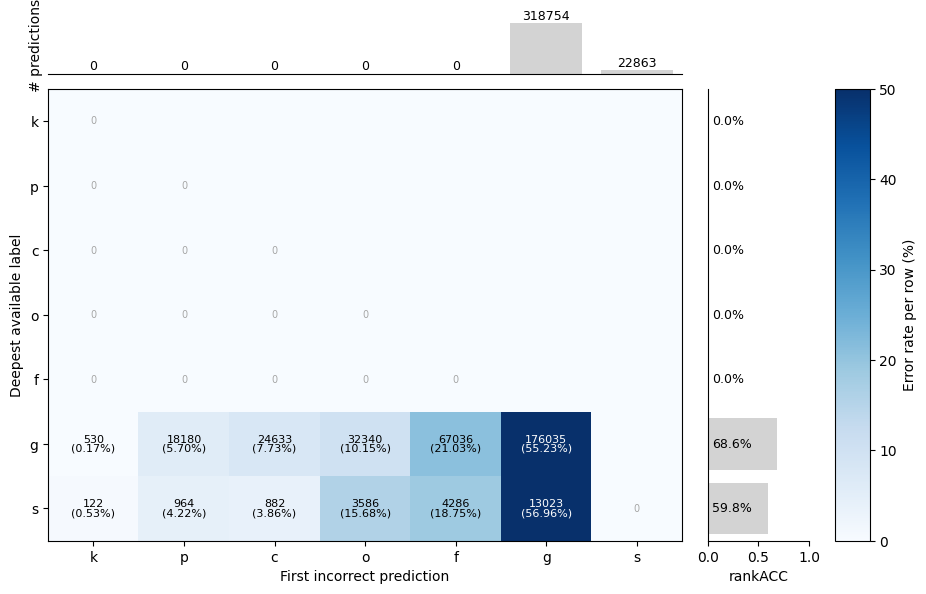

In [23]:
fig, axes = plot_error_origin_matrix_rowpct_colored(
    counts_nc,
    meta_nc,
    title=(),#"Error-origin matrix with rankACC (TEST, affected OTUs) — non-corrupted SILVA gold",
    ranks=RANKS,
    df=df_nc2,                 # to show OTUs and N predictions
    otu_col="otu_id",          # or "otu_key"; your df has otu_key (string) and otu_id (numeric)
    show_zeros_lower=True,
    show_percent_text=True,
    vmax_pct=50.0,
    vmin_pct=0.0,
)


In [31]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Rectangle

RANKS = ["k", "p", "c", "o", "f", "g", "s"]

def plot_error_origin_matrix_rowpct_colored_genus_species(
    counts,
    meta,
    title,
    ranks=RANKS,
    df=None,
    otu_col="otu_id",
    show_zeros_lower=True,          # kept for signature compatibility
    show_percent_text: bool = True,
    vmax_pct: float = 5.0,
    vmin_pct: float = 0.0,
):
    """
    Genus+Species error-origin matrix (2-row variant):
      - Heatmap shows rows ['g','s'] across columns k..s.
      - Top bar plot shows denominators (# predictions) for ALL deepest ranks (k..s).
      - Bottom shows two rankACC bars (g and s).
      - The 'g' column is overlaid in gray (for both rows) to indicate a "non-strict error bucket".
    """

    ranks = list(ranks)
    for r in ("g", "s"):
        if r not in ranks:
            raise ValueError("Expected ranks to include both 'g' and 's'.")

    row_ranks = ["g", "s"]

    # ---- Heatmap counts (two rows) ----
    mat_counts = counts.loc[row_ranks, ranks].fillna(0).astype(int)
    data_counts = mat_counts.to_numpy()  # shape (2, C)

    # Denominators per row for row-% normalization
    denom_by_row = []
    for rr in row_ranks:
        denom_by_row.append(float(meta.loc[rr, "n_preds_strict"]) if rr in meta.index else 0.0)
    denom_by_row = np.array(denom_by_row, dtype=float)

    # rankACC per row (g,s)
    rankacc_by_row = []
    for rr in row_ranks:
        v = float(meta.loc[rr, "rankACC_mean"]) if rr in meta.index else 0.0
        if not np.isfinite(v):
            v = 0.0
        rankacc_by_row.append(v)
    rankacc_by_row = np.array(rankacc_by_row, dtype=float)

    # ---- Top denominators across ALL ranks (k..s) ----
    n_preds_all = meta.loc[ranks, "n_preds_strict"].fillna(0).astype(int).to_numpy()

    # ---- Row-normalized percent for heatmap colors ----
    data_pct = np.zeros_like(data_counts, dtype=float)
    for i in range(len(row_ranks)):
        denom = denom_by_row[i]
        if denom > 0:
            data_pct[i, :] = 100.0 * (data_counts[i, :] / denom)

    # -------------------------------------------------
    # Layout
    # -------------------------------------------------
    fig = plt.figure(figsize=(10.6, 5.2))
    gs = GridSpec(
        3, 2,
        height_ratios=[0.9, 1.35, 0.65],
        width_ratios=[20, 1.1],
        hspace=0.28,
        wspace=0.10
    )

    # -------------------------
    # Top denominators (all ranks)
    # -------------------------
    ax_top = fig.add_subplot(gs[0, 0])
    ax_top.bar(range(len(ranks)), n_preds_all, color="lightgray", edgecolor="none")
    ax_top.set_xlim(-0.5, len(ranks) - 0.5)
    ax_top.set_ylabel("# predictions")
    ax_top.set_yticks([])
    ax_top.tick_params(axis="y", left=False, labelleft=False)
    ax_top.spines["left"].set_visible(False)
    ax_top.set_xticks([])
    ax_top.tick_params(axis="x", bottom=False, labelbottom=False)
    ax_top.spines["right"].set_visible(False)
    ax_top.spines["top"].set_visible(False)

    ymax = max(1, int(n_preds_all.max()) if len(n_preds_all) else 1)
    ax_top.set_ylim(0, ymax * 1.12)
    for i, n in enumerate(n_preds_all):
        if n > 0:
            ax_top.text(i, n + 0.01 * ymax, f"{n}", ha="center", va="bottom", fontsize=9)

    # -------------------------
    # Heatmap (rows: g, s)
    # -------------------------
    ax_hm = fig.add_subplot(gs[1, 0], sharex=ax_top)

    im = ax_hm.imshow(
        data_pct,
        aspect="auto",
        cmap="Blues",
        vmin=vmin_pct,
        vmax=vmax_pct,
    )

    ax_hm.set_xticks(range(len(ranks)))
    ax_hm.set_xticklabels(ranks)
    ax_hm.set_yticks(range(len(row_ranks)))
    ax_hm.set_yticklabels(row_ranks)

    # Remove x-axis label per request (keep only k..s tick labels)
    ax_hm.set_xlabel("")
    ax_hm.set_ylabel("Available label")

    j_g = ranks.index("g")

    # Overlay the entire 'g' column in gray for BOTH rows (no black borders)
    for i in range(len(row_ranks)):
        ax_hm.add_patch(
            Rectangle(
                (j_g - 0.5, i - 0.5), 1.0, 1.0,
                facecolor="lightgray",
                alpha=1.0,
                edgecolor="none",     # <-- no black box
                linewidth=0.0,
                zorder=2,             # above heatmap, below text
            )
        )

    # Annotate: counts and (row %)
    for i in range(data_counts.shape[0]):
        for j in range(data_counts.shape[1]):
            v = int(data_counts[i, j])
            pct = float(data_pct[i, j])

            if v > 0:
                txt = f"{v}\n({pct:.2f}%)" if show_percent_text else f"{v}"

                # gray column text always black; others adaptive
                if j == j_g:
                    txt_color = "black"
                else:
                    txt_color = "white" if pct > 0.6 * vmax_pct else "black"

                ax_hm.text(
                    j, i, txt,
                    ha="center", va="center",
                    fontsize=8,
                    color=txt_color,
                    linespacing=0.9,
                    zorder=3,
                )
            else:
                ax_hm.text(j, i, "0", ha="center", va="center", fontsize=7, color="0.65", zorder=3)

    # -------------------------
    # Bottom rankACC bars (g and s)
    # -------------------------
    ax_ra = fig.add_subplot(gs[2, 0])
    y = np.arange(len(row_ranks))
    ax_ra.barh(y, rankacc_by_row, color="lightgray", edgecolor="none")
    ax_ra.set_xlim(0.0, 1.0)
    ax_ra.set_yticks(y)
    ax_ra.set_yticklabels(["rankACC (g)", "rankACC (s)"])
    ax_ra.invert_yaxis()  # keep g on top, s below

    for i, v in enumerate(rankacc_by_row):
        ax_ra.text(
            0.01, i,
            f"{v*100:.1f}%",
            va="center", ha="left",
            fontsize=10,
            color="black",
        )

    ax_ra.spines["top"].set_visible(False)
    ax_ra.spines["right"].set_visible(False)

    # -------------------------
    # Colorbar
    # -------------------------
    ax_cb = fig.add_subplot(gs[:, 1])
    cbar = fig.colorbar(im, cax=ax_cb)
    cbar.set_label("Error rate per row (%)")

    return fig, (ax_top, ax_hm, ax_ra, ax_cb)


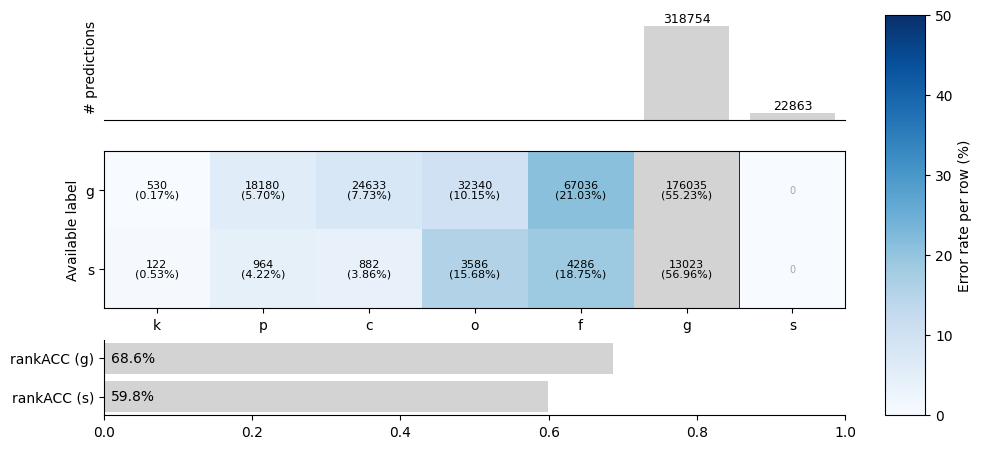

In [33]:
fig, axes = plot_error_origin_matrix_rowpct_colored_genus_species(
    counts=counts_nc,
    meta=meta_nc,
    title="Genus corruption (g+s rows)",
    df=df_nc2,          # optional
    otu_col="otu_key",  # optional
    vmax_pct=50.0,
)
plt.show()


318754+22863 = 341617

176035, 13023

# genus prediction breakdown:

In [38]:
161918+13828+289


176035

In [35]:


RANKS = ("k","p","c","o","f","g","s")

# -----------------------------
# 0) Ensure ok_* columns exist and are boolean
# -----------------------------
df = df_nc.copy()  # or df_aff, depending on what you want to analyze

for r in RANKS:
    c = f"ok_{r}"
    if c not in df.columns:
        # ok_* are meaningful only when gold exists; but we keep your convention
        df[c] = (df.get(f"pred_{r}", "").fillna("").astype(str) == df.get(f"gold_{r}", "").fillna("").astype(str))
    df[c] = df[c].fillna(False).astype(bool)

# -----------------------------
# 1) Deepest-rank helper (name-based, empty string => missing)
# -----------------------------
def deepest_rank_from_gold(row, ranks=RANKS):
    for r in reversed(ranks):
        v = row.get(f"gold_{r}", "")
        if isinstance(v, float) and np.isnan(v):
            continue
        if str(v).strip() != "":
            return r
    return None

if "deepest_rank" not in df.columns:
    df["deepest_rank"] = df.apply(deepest_rank_from_gold, axis=1)

# -----------------------------
# 2) Cleaning / “closest genus” rules
#    Goal: treat common suffix variants as equivalent
# -----------------------------
_VARIANT_SUFFIX_RE = re.compile(
    r"(_?(group|grp|clade|cluster|complex|genogroup|lineage|subgroup|subgrp|"
    r"ucg|uncultured|unclassified|candidate|candidatus|sp|spp|bacterium|bacteria)"
    r"(_.*)?)$",
    flags=re.IGNORECASE,
)

_NUM_SUFFIX_RE = re.compile(r"(_?\d+)$")

def clean_genus_name(x: str) -> str:
    """
    Normalize genus-like strings to compare 'closest' variants.
    Conservative: only strips very common suffix patterns and trailing numbers.
    """
    if x is None:
        return ""
    s = str(x).strip()
    s = s.strip("'\"")
    s = s.split("(", 1)[0].strip()
    s = s.replace(" ", "_")
    s = re.sub(r"_+", "_", s).strip("_")

    # strip trailing numeric variants: e.g., Ruminiclostridium_5 -> Ruminiclostridium
    s = _NUM_SUFFIX_RE.sub("", s)

    # strip common suffix variants: e.g., Genus_UCG-005 / Genus_group / Genus_clade_X
    s = _VARIANT_SUFFIX_RE.sub("", s)

    s = re.sub(r"_+", "_", s).strip("_")
    return s

def is_unk_like(x: str) -> bool:
    if x is None:
        return True
    s = str(x).strip()
    if s == "":
        return True
    u = s.upper()
    return ("UNK" in u) or (s.lower() in {"unknown", "__unknown", "unidentified"})

# -----------------------------
# 3) Classify genus-row outcomes
#    Rows of interest: deepest_rank == 'g' and genus is wrong (ok_g=False)
# -----------------------------
def classify_genus_row(row) -> str:
    pg = row.get("pred_g", "")
    gg = row.get("gold_g", "")

    # Case 1: predicted UNK/empty at genus => "good" for genus-corruption setup
    if is_unk_like(pg):
        return "UNK_genus"

    # Case 2: predicted some genus variant that matches gold after normalization
    gold_clean = clean_genus_name(gg)
    pred_clean = clean_genus_name(pg)
    if gold_clean and pred_clean and (gold_clean.lower() == pred_clean.lower()):
        return "Closest_genus"

    # Case 3: otherwise it predicted a concrete genus => "bad"
    return "Other_genus"

# -----------------------------
# 4) Subset: genus-row errors
#    deepest must be genus and genus is wrong
#    (Optionally require all upper ranks correct; keep this ON for parity with species-only logic)
# -----------------------------
genus_row = (df["deepest_rank"] == "g")

# Strictly “genus-only error” analogue:
# correct up to family, wrong at genus
genus_only_error = (
    genus_row &
    df["ok_k"] & df["ok_p"] & df["ok_c"] & df["ok_o"] & df["ok_f"] &
    (~df["ok_g"])
)

df_genus_only = df.loc[genus_only_error].copy()
df_genus_only["genus_error_mode"] = df_genus_only.apply(classify_genus_row, axis=1)

# -----------------------------
# 5) Denominator = ALL genus-row predictions (matches heatmap row denominator)
# -----------------------------
n_preds_genus_row = int(genus_row.sum())
if n_preds_genus_row <= 0:
    raise ValueError("No rows with deepest_rank == 'g' found; cannot compute genus-row percentages.")

mode_counts = df_genus_only["genus_error_mode"].value_counts(dropna=False).to_frame("count")
mode_counts["pct_of_all_genus_row_preds"] = (100.0 * mode_counts["count"] / n_preds_genus_row).round(2)

display(mode_counts)

print(
    "[CHECK] genus-row denom =", n_preds_genus_row,
    "| n_genus_only =", len(df_genus_only),
    "| sum pct_of_all_genus_row_preds =",
    float(mode_counts["pct_of_all_genus_row_preds"].sum()),
    "| expected <= (g,g) cell % from matrix"
)

# Optional: show examples
cols = ["otu_key", "gold_f", "pred_f", "gold_g", "pred_g"]
display(df_genus_only[df_genus_only["genus_error_mode"] == "UNK_genus"].head(25)[cols])
display(df_genus_only[df_genus_only["genus_error_mode"] == "Closest_genus"].head(25)[cols])
display(df_genus_only[df_genus_only["genus_error_mode"] == "Other_genus"].head(25)[cols])


,count,pct_of_all_genus_row_preds
genus_error_mode,,
UNK_genus,161918,50.80
Other_genus,13828,4.34
Closest_genus,289,0.09


[CHECK] genus-row denom = 318754 | n_genus_only = 176035 | sum pct_of_all_genus_row_preds = 55.230000000000004 | expected <= (g,g) cell % from matrix


,otu_key,gold_f,pred_f,gold_g,pred_g
4,90_15358;96_41933;97_53597,Paenibacillaceae,Paenibacillaceae,Thermobacillus,UNK
5,90_1167;96_46508;97_59705,Chitinophagaceae,Chitinophagaceae,Taibaiella,UNK
7,90_114;96_33491;97_42458,Xanthomonadaceae,Xanthomonadaceae,Pseudofulvimonas,UNK
13,90_3570;96_40817;97_52107,Chitinophagaceae,Chitinophagaceae,Taibaiella,UNK
15,90_16185;96_17512;97_21563,Paenibacillaceae,Paenibacillaceae,Thermobacillus,UNK
19,90_7;96_1835;97_16214,Alcaligenaceae,Alcaligenaceae,Pigmentiphaga,UNK
20,90_16;96_2483;97_3033,Lachnospiraceae,Lachnospiraceae,Lachnoclostridium,UNK
21,90_16;96_29685;97_37472,Lachnospiraceae,Lachnospiraceae,Incertae_Sedis,UNK
22,90_16;96_6294;97_7551,Lachnospiraceae,Lachnospiraceae,Lachnospiraceae_NK4A136_group,UNK
24,90_16;96_8514;97_10246,Lachnospiraceae,Lachnospiraceae,Lachnospiraceae_XPB1014_group,UNK


,otu_key,gold_f,pred_f,gold_g,pred_g
179,90_34;96_20061;97_24934,Clostridiaceae_1,Clostridiaceae_1,Clostridium_sensu_stricto_6,Clostridium_sensu_stricto_1
463,90_34;96_20061;97_24934,Clostridiaceae_1,Clostridiaceae_1,Clostridium_sensu_stricto_6,Clostridium_sensu_stricto_1
659,90_34;96_20061;97_24934,Clostridiaceae_1,Clostridiaceae_1,Clostridium_sensu_stricto_6,Clostridium_sensu_stricto_1
700,90_6860;96_30242;97_38224,cvE6,cvE6,Chlamydiales_bacterium_cvE21,Chlamydiales_bacterium_cvE16
712,90_34;96_20061;97_24934,Clostridiaceae_1,Clostridiaceae_1,Clostridium_sensu_stricto_6,Clostridium_sensu_stricto_1
1223,90_34;96_20061;97_24934,Clostridiaceae_1,Clostridiaceae_1,Clostridium_sensu_stricto_6,Clostridium_sensu_stricto_1
1233,90_6860;96_30242;97_38224,cvE6,cvE6,Chlamydiales_bacterium_cvE21,Chlamydiales_bacterium_cvE16
1639,90_34;96_20061;97_24934,Clostridiaceae_1,Clostridiaceae_1,Clostridium_sensu_stricto_6,Clostridium_sensu_stricto_1
1666,90_6860;96_30242;97_38224,cvE6,cvE6,Chlamydiales_bacterium_cvE21,Chlamydiales_bacterium_cvE16
1696,90_34;96_20061;97_24934,Clostridiaceae_1,Clostridiaceae_1,Clostridium_sensu_stricto_6,Clostridium_sensu_stricto_1


,otu_key,gold_f,pred_f,gold_g,pred_g
10,90_15358;96_41866;97_53505,Paenibacillaceae,Paenibacillaceae,Thermobacillus,Paenibacillus
14,90_103;96_11585;97_14011,Porphyromonadaceae,Porphyromonadaceae,Proteiniphilum,Petrimonas
36,90_217;96_23075;97_28854,Veillonellaceae,Veillonellaceae,Allisonella,Dialister
63,90_45;96_367;97_831,Lactobacillaceae,Lactobacillaceae,Lactobacillus,Pediococcus
89,90_55;96_801;97_1617,Veillonellaceae,Veillonellaceae,Selenomonas_3,Centipeda
93,90_15;96_102;97_109,Streptomycetaceae,Streptomycetaceae,Streptomyces,Kitasatospora
238,90_13895;96_60652;97_78521,ASCC02,ASCC02,unidentified,Granulicatella_sp._oral_clone_ASC02
245,90_135;96_419;97_474,Erysipelotrichaceae,Erysipelotrichaceae,Incertae_Sedis,Faecalitalea
290,90_1;96_491;97_560,Comamonadaceae,Comamonadaceae,Acidovorax,Simplicispira
305,90_1015;96_26762;97_33617,Planctomycetaceae,Planctomycetaceae,Pir4_lineage,Bythopirellula


In [40]:
RANKS = ("k","p","c","o","f","g","s")

# ============================================================
# Genus-corruption "gray g-column" breakdown
# Counts rows that land in:
#   - (g,g): available label = genus, first wrong = genus
#   - (s,g): available label = species, first wrong = genus
#
# Categories:
#   1) UNK_genus        : pred_g is UNK-like (good)
#   2) Closest_genus    : pred_g matches gold_g after normalization (good)
#   3) Other_genus      : any other concrete genus prediction (bad)
# Denominator:
#   all rows in the union of (g,g) and (s,g)
# ============================================================

df = df_nc.copy()

# -----------------------------
# 0) Ensure ok_* columns exist and are boolean
# -----------------------------
for r in RANKS:
    c = f"ok_{r}"
    if c not in df.columns:
        df[c] = (
            df.get(f"pred_{r}", "").fillna("").astype(str)
            == df.get(f"gold_{r}", "").fillna("").astype(str)
        )
    df[c] = df[c].fillna(False).astype(bool)

# -----------------------------
# 1) Ensure deepest_rank exists (name-based, empty => missing)
# -----------------------------
def deepest_rank_from_gold(row, ranks=RANKS):
    for r in reversed(ranks):
        v = row.get(f"gold_{r}", "")
        if isinstance(v, float) and np.isnan(v):
            continue
        if str(v).strip() != "":
            return r
    return None

if "deepest_rank" not in df.columns:
    df["deepest_rank"] = df.apply(deepest_rank_from_gold, axis=1)

# -----------------------------
# 2) Genus normalization for "closest" variants
# -----------------------------
_VARIANT_SUFFIX_RE = re.compile(
    r"(_?(group|grp|clade|cluster|complex|genogroup|lineage|subgroup|subgrp|"
    r"ucg|uncultured|unclassified|candidate|candidatus|sp|spp|bacterium|bacteria)"
    r"(_.*)?)$",
    flags=re.IGNORECASE,
)
_NUM_SUFFIX_RE = re.compile(r"(_?\d+)$")

def clean_genus_name(x: str) -> str:
    if x is None:
        return ""
    s = str(x).strip()
    s = s.strip("'\"")
    s = s.split("(", 1)[0].strip()
    s = s.replace(" ", "_")
    s = re.sub(r"_+", "_", s).strip("_")
    s = _NUM_SUFFIX_RE.sub("", s)        # e.g. Genus_5 -> Genus
    s = _VARIANT_SUFFIX_RE.sub("", s)    # e.g. Genus_group -> Genus
    s = re.sub(r"_+", "_", s).strip("_")
    return s

def is_unk_like(x: str) -> bool:
    if x is None:
        return True
    s = str(x).strip()
    if s == "":
        return True
    u = s.upper()
    return ("UNK" in u) or (s.lower() in {"unknown", "__unknown", "unidentified"})

def classify_genus_mode(row) -> str:
    pg = row.get("pred_g", "")
    gg = row.get("gold_g", "")

    if is_unk_like(pg):
        return "UNK_genus"

    gc = clean_genus_name(gg)
    pc = clean_genus_name(pg)
    if gc and pc and (gc.lower() == pc.lower()):
        return "Closest_genus"

    return "Other_genus"

# -----------------------------
# 3) Select rows corresponding to the gray 'g' column in your 2-row plot:
#    - correct up to family
#    - wrong at genus
#    - available label is genus or species (deepest_rank in {'g','s'})
# -----------------------------
gray_g_mask = (
    df["ok_k"] & df["ok_p"] & df["ok_c"] & df["ok_o"] & df["ok_f"] &
    (~df["ok_g"]) &
    (df["deepest_rank"].isin(["g", "s"]))
)

df_gray_g = df.loc[gray_g_mask].copy()
df_gray_g["genus_error_mode"] = df_gray_g.apply(classify_genus_mode, axis=1)

# -----------------------------
# 4) Denominator = ALL rows in the gray 'g' column (g,g) + (s,g)
# -----------------------------
denom = int(len(df_gray_g))
if denom <= 0:
    raise ValueError("No rows found for the gray 'g' column selection; check ok_* and deepest_rank logic.")

mode_counts = df_gray_g["genus_error_mode"].value_counts(dropna=False).to_frame("count")
mode_counts["pct_of_gray_g_column"] = (100.0 * mode_counts["count"] / denom).round(2)

display(mode_counts)

print(
    "[CHECK] gray g-column denom =", denom,
    "| sum pct_of_gray_g_column =",
    float(mode_counts["pct_of_gray_g_column"].sum())
)




,count,pct_of_gray_g_column
genus_error_mode,,
UNK_genus,173033,91.52
Other_genus,15736,8.32
Closest_genus,289,0.15


[CHECK] gray g-column denom = 189058 | sum pct_of_gray_g_column = 99.99000000000001
